# Setup

In [1]:
import gzip
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
dataset = []

f = gzip.open("steam_games.json.gz")
for l in f:
    d = eval(l)
    dataset.append(d)
        
f.close()

In [3]:
len(dataset)

32135

In [4]:
filtered_dataset = [game for game in dataset if 'sentiment' in game and game['sentiment']]
print(f"Number of records with sentiment: {len(filtered_dataset)}")

Number of records with sentiment: 24953


In [5]:
sentiments = [game['sentiment'] for game in dataset if 'sentiment' in game]
unique_sentiments = set(sentiments)

print("Unique sentiment values:")
print(unique_sentiments)

Unique sentiment values:
{'Very Positive', '4 user reviews', 'Mostly Negative', '8 user reviews', '3 user reviews', '5 user reviews', 'Mixed', 'Overwhelmingly Positive', '1 user reviews', '2 user reviews', '9 user reviews', '7 user reviews', 'Negative', '6 user reviews', 'Overwhelmingly Negative', 'Mostly Positive', 'Very Negative', 'Positive'}


In [6]:
####################
###### Part 1 ######
####################

In [7]:
# 1.1: Dataset Overview

## data size
print(f"Number of records in the original dataset: {len(dataset)}") # before filtering
filtered_dataset = [game for game in dataset if 'sentiment' in game and game['sentiment']]
print(f"Number of records with sentiment: {len(filtered_dataset)}") # after filtering

## keys
print("Keys in the first record of the filtered dataset:")
print(filtered_dataset[0].keys())

## Feature summary
# Summarize features: Categorical, Numerical, and Date
categorical_features = ['genres', 'tags', 'publisher', 'developer', 'sentiment']
numerical_features = ['price', 'discount_price']
date_feature = 'release_date'

Number of records in the original dataset: 32135
Number of records with sentiment: 24953
Keys in the first record of the filtered dataset:
dict_keys(['publisher', 'genres', 'app_name', 'sentiment', 'title', 'url', 'release_date', 'tags', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer'])


Categorized Sentiment Distribution (Ordered):
Overwhelmingly Positive: 303 (1.21%)
Very Positive: 3868 (15.50%)
Mostly Positive: 2744 (11.00%)
Positive: 3281 (13.15%)
Mixed: 4103 (16.44%)
Negative: 123 (0.49%)
Mostly Negative: 802 (3.21%)
Very Negative: 29 (0.12%)
Overwhelmingly Negative: 7 (0.03%)
Not Enough Information: 9693 (38.85%)


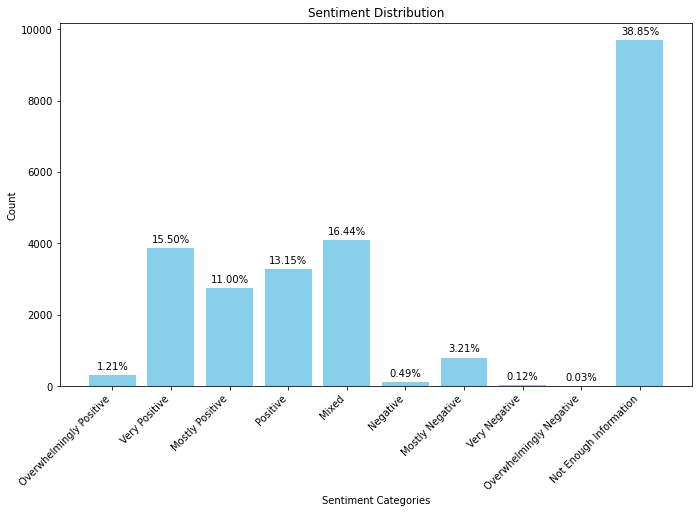

In [8]:
# 1.2: Sentiment Analysis
## filtering sentiments 
def filter_sentiment(sentiment):
    if 'user reviews' in sentiment.lower():
        return 'Not Enough Information'
    return sentiment

filtered_sentiments = [filter_sentiment(game['sentiment']) for game in filtered_dataset]

sentiment_order = [ "Overwhelmingly Positive", "Very Positive", "Mostly Positive", "Positive", "Mixed", 
    "Negative", "Mostly Negative", "Very Negative", "Overwhelmingly Negative", "Not Enough Information"]

sentiment_counts = Counter(filtered_sentiments)
sorted_sentiment_counts = {sentiment: sentiment_counts[sentiment] for sentiment in sentiment_order if sentiment in sentiment_counts}
print("Categorized Sentiment Distribution (Ordered):")
total_records_len = len(filtered_dataset)
for sentiment, count in sorted_sentiment_counts.items():
    print(f"{sentiment}: {count} ({count / total_records_len * 100:.2f}%)")

l1 = list(sorted_sentiment_counts.keys())
v1 = list(sorted_sentiment_counts.values())
p1 = [f"{(value / total_records_len * 100):.2f}%" for value in v1]

plt.figure(figsize=(10, 6))
bars = plt.bar(l1, v1, color='skyblue')

for bar, p in zip(bars, p1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, p, ha='center', va='bottom')

plt.xlabel('Sentiment Categories')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')  
plt.show()


Price Categories Distribution:
Free: 1704 (6.83%)
Paid: 22462 (90.02%)
Not Enough Information: 787 (3.15%)
Number of paid games: 22462
Average price: 9.92
Median price: 5.99
Maximum price: 771.71


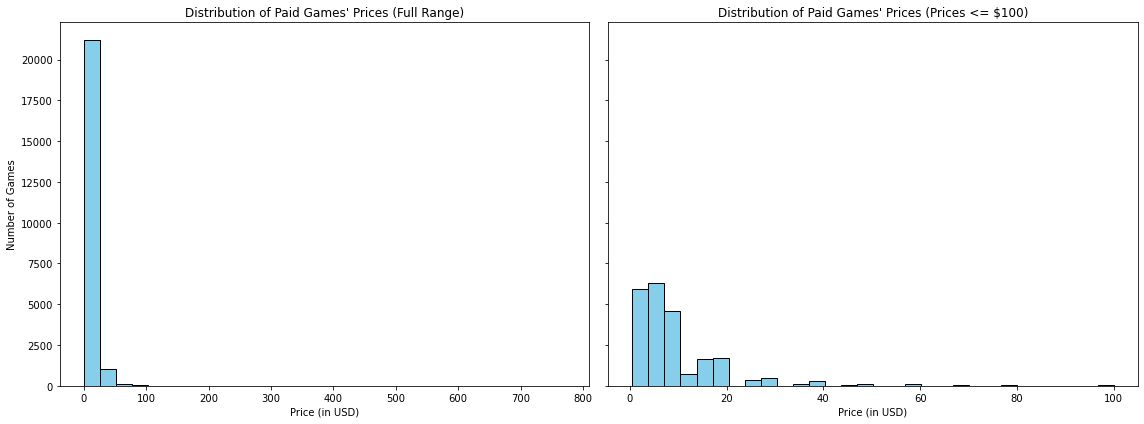

In [9]:
# 1.3: Price Analysis 
def categorize_price(price):
    if isinstance(price, str) and 'free' in price.lower():
        return 'Free'
    elif isinstance(price, str):
        return 'Not Enough Information'
    elif isinstance(price, (int, float)):
        if price == 0:
            return 'Free'
        else:
            return 'Paid'
    return 'Not Enough Information'

price_categories = [categorize_price(game['price']) if 'price' in game else 'Not Enough Information'
    for game in filtered_dataset
]

price_category_counts = Counter(price_categories)
print("Price Categories Distribution:")
for category, count in price_category_counts.items():
    print(f"{category}: {count} ({count / len(filtered_dataset) * 100:.2f}%)")

numerical_prices = [float(game['price']) for game in filtered_dataset
    if 'price' in game and isinstance(game['price'], (int, float)) and game['price'] > 0]

print(f"Number of paid games: {len(numerical_prices)}")
print(f"Average price: {np.mean(numerical_prices):.2f}")
print(f"Median price: {np.median(numerical_prices):.2f}")
print(f"Maximum price: {np.max(numerical_prices):.2f}")

prices_less_than_100 = [price for price in numerical_prices if price <= 100]
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# hist 1
axes[0].hist(numerical_prices, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Paid Games\' Prices (Full Range)')
axes[0].set_xlabel('Price (in USD)')
axes[0].set_ylabel('Number of Games')

# hist 2
axes[1].hist(prices_less_than_100, bins=30, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Paid Games\' Prices (Prices <= $100)')
axes[1].set_xlabel('Price (in USD)')

plt.tight_layout()
plt.show()

Top Genres:
Indie: 12424 (49.79%)
Action: 9559 (38.31%)
Adventure: 6958 (27.88%)
Casual: 5947 (23.83%)
Strategy: 5091 (20.40%)
Simulation: 4817 (19.30%)
RPG: 3902 (15.64%)
Free to Play: 1493 (5.98%)
Early Access: 1333 (5.34%)
Sports: 932 (3.74%)


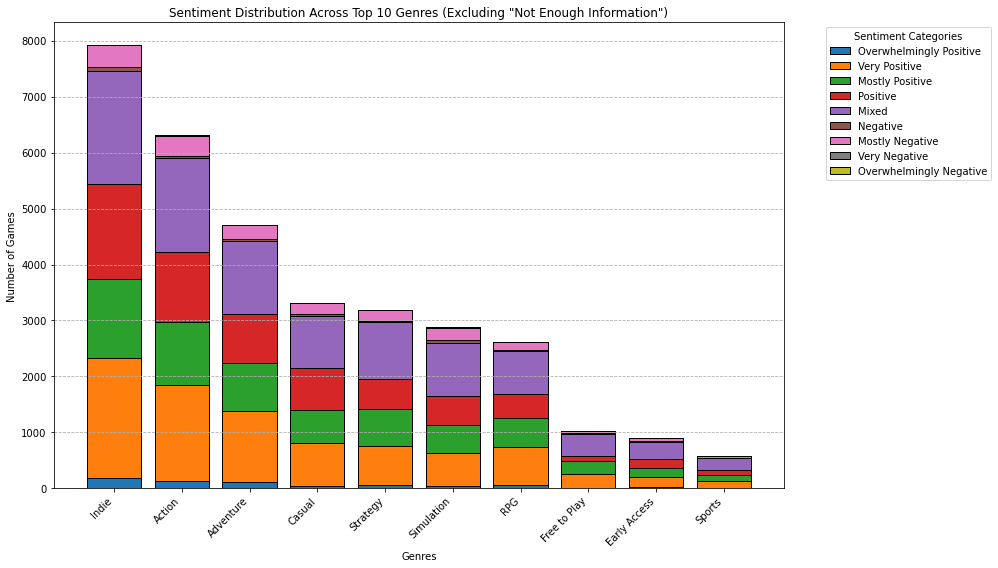

In [10]:
# 1.4: Genre Analysis 
all_genres = [genre for game in filtered_dataset if 'genres' in game
    for genre in game['genres']]

genre_counts = Counter(all_genres)
top_genres = genre_counts.most_common(10)  
print("Top Genres:")
for genre, count in top_genres:
    print(f"{genre}: {count} ({count / len(filtered_dataset) * 100:.2f}%)")

valid_sentiments = [sentiment for sentiment in sentiment_order if sentiment != "Not Enough Information"]
genre_sentiment_data = {genre: Counter() for genre, _ in top_genres}

for game in filtered_dataset:
    if 'genres' in game and 'sentiment' in game:
        sentiment = filter_sentiment(game['sentiment'])
        if sentiment != "Not Enough Information":
            for genre in game['genres']:
                if genre in genre_sentiment_data:
                    genre_sentiment_data[genre][sentiment] += 1

genre_labels = [genre for genre, _ in top_genres]
sentiment_values = {sentiment: [genre_sentiment_data[genre].get(sentiment, 0) for genre in genre_labels] 
                    for sentiment in valid_sentiments}

plt.figure(figsize=(14, 8))
bottoms = np.zeros(len(genre_labels))

for sentiment in valid_sentiments:
    plt.bar(genre_labels, sentiment_values[sentiment], bottom=bottoms, label=sentiment, color=None, edgecolor="black")
    bottoms += sentiment_values[sentiment]

plt.xlabel('Genres')
plt.ylabel('Number of Games')
plt.title('Sentiment Distribution Across Top 10 Genres (Excluding "Not Enough Information")')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()


Top Years with Most Releases:
2017: 6520
2016: 5383
2015: 4151
2014: 2367
2013: 1291
2012: 940
2011: 522
2010: 398
2009: 310
2008: 195


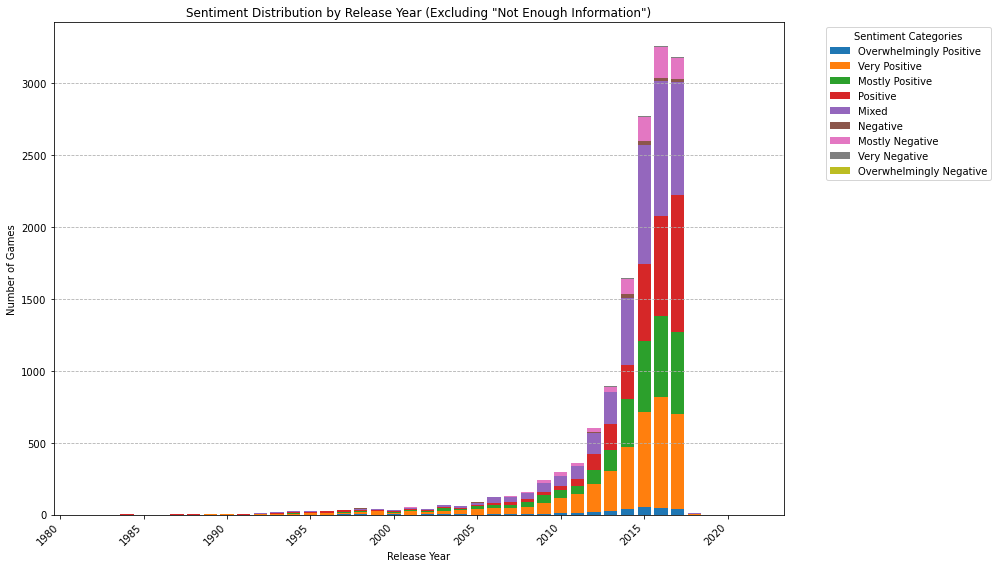

In [11]:
# 1.5: Release Date Analysis
def parse_date(date_string):
    date_formats = ['%Y-%m-%d', '%b %Y', '%B %Y']  
    for fmt in date_formats:
        try:
            return datetime.strptime(date_string, fmt).year
        except ValueError:
            continue
    return None  

release_years = [
    parse_date(game['release_date']) 
    for game in filtered_dataset if 'release_date' in game and game['release_date']
]

release_years = [year for year in release_years if year is not None]
release_year_counts = Counter(release_years)
top_release_years = release_year_counts.most_common(10) 
print("Top Years with Most Releases:")
for year, count in top_release_years:
    print(f"{year}: {count}")

sentiment_year_data = {}
for game in filtered_dataset:
    if 'release_date' in game and game['release_date'] and 'sentiment' in game:
        year = parse_date(game['release_date'])  
        sentiment = filter_sentiment(game['sentiment'])  
        if year is not None and sentiment != "Not Enough Information":
            if year not in sentiment_year_data:
                sentiment_year_data[year] = Counter()
            sentiment_year_data[year][sentiment] += 1

sorted_years = sorted(sentiment_year_data.keys())
valid_sentiments = [sentiment for sentiment in sentiment_order if sentiment != "Not Enough Information"]
yearly_sentiments = {sentiment: [sentiment_year_data[year].get(sentiment, 0) for year in sorted_years]
                     for sentiment in valid_sentiments}

plt.figure(figsize=(14, 8))
bottoms = np.zeros(len(sorted_years))
for sentiment in valid_sentiments:
    plt.bar(sorted_years, yearly_sentiments[sentiment], bottom=bottoms, label=sentiment, width=0.8)
    bottoms += yearly_sentiments[sentiment]

plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.title('Sentiment Distribution by Release Year (Excluding "Not Enough Information")')
plt.legend(title='Sentiment Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()


Top Publishers:
Dovetail Games - Trains: 349 (1.40%)
Paradox Interactive: 252 (1.01%)
Ubisoft: 245 (0.98%)
Degica: 237 (0.95%)
SEGA: 214 (0.86%)
Activision: 189 (0.76%)
Dovetail Games - Flight: 182 (0.73%)
THQ Nordic: 146 (0.59%)
Strategy First: 140 (0.56%)
KISS ltd: 131 (0.52%)
KOEI TECMO GAMES CO., LTD.: 131 (0.52%)
Square Enix: 129 (0.52%)
Capcom: 126 (0.50%)
BANDAI NAMCO Entertainment: 109 (0.44%)
Slitherine Ltd.: 109 (0.44%)


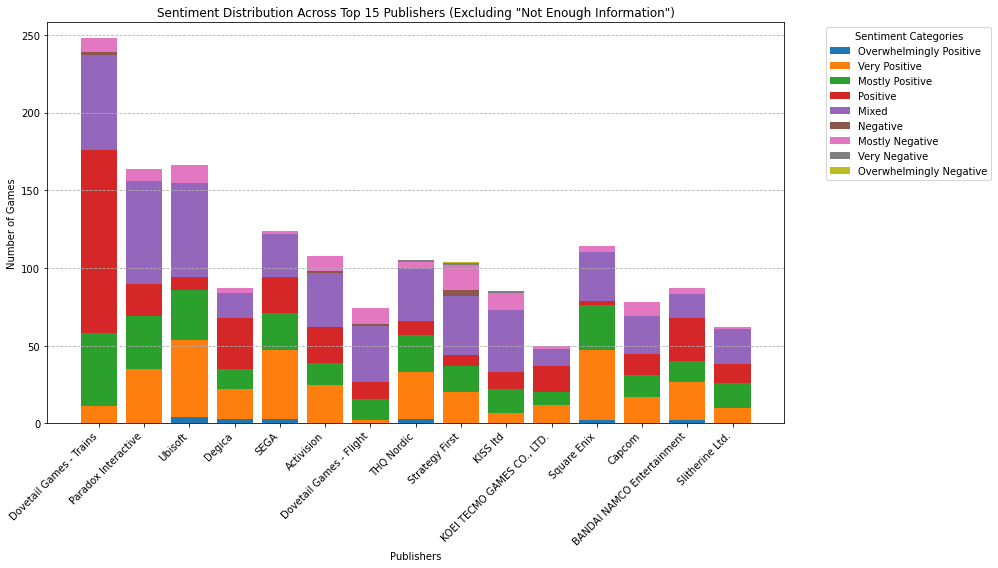

In [12]:
# 1.6 Publisher Analysis 
publisher_counts = Counter([game['publisher'] for game in filtered_dataset if 'publisher' in game and game['publisher']])

top_publishers = publisher_counts.most_common(15)
print("Top Publishers:")
for publisher, count in top_publishers:
    print(f"{publisher}: {count} ({count / len(filtered_dataset) * 100:.2f}%)")

publisher_sentiment_data = {publisher: Counter() for publisher, _ in top_publishers}

for game in filtered_dataset:
    if 'publisher' in game and 'sentiment' in game:
        sentiment = filter_sentiment(game['sentiment'])
        if sentiment != "Not Enough Information" and game['publisher'] in publisher_sentiment_data:
            publisher_sentiment_data[game['publisher']][sentiment] += 1

publisher_labels = [publisher for publisher, _ in top_publishers]
valid_sentiments = [sentiment for sentiment in sentiment_order if sentiment != "Not Enough Information"]
sentiment_values_by_publisher = {
    sentiment: [
        publisher_sentiment_data[publisher].get(sentiment, 0) for publisher, _ in top_publishers
    ]
    for sentiment in valid_sentiments
}

plt.figure(figsize=(14, 8))
bottoms = np.zeros(len(publisher_labels))

for sentiment in valid_sentiments:
    plt.bar(
        publisher_labels,
        sentiment_values_by_publisher[sentiment],
        bottom=bottoms,
        label=sentiment
    )
    bottoms += sentiment_values_by_publisher[sentiment]

plt.ylim(0, max(bottoms) + 10) 
plt.xlabel('Publishers')
plt.ylabel('Number of Games')
plt.title('Sentiment Distribution Across Top 15 Publishers (Excluding "Not Enough Information")')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()


# Part 2

2. **Predictive Task and Evaluation**
   - Define a predictive task and describe evaluation methods.  
TASK: (maybe) predicting a game’s sentiment (whether it’ll have ‘overwhelmingly positive’, ‘very positive’ / ‘overwhelmingly negative, ‘very negative’, …) based on its features?
Evaluation Metrics:
We can maybe use metrics like accuracy, precision, recall, f1 score, … 
Cross validation ?
   - Outline relevant baselines for comparison and assess the model's validity. 
BASELINE: 
Comparison & model’s validity 
   - Detail feature selection and data preprocessing.
Categorical features:
Numerical features:
Binary features:


In [13]:
# Create feature extractor
def feature(game):
    feat = {}
    
    # Categorical features
    feat['genres'] = ','.join(game.get('genres', []))  # Combine genres into a single string
    feat['tags'] = ','.join(game.get('tags', []))  # Combine tags into a single string
    feat['publisher'] = game.get('publisher', "Unknown")
    feat['developer'] = game.get('developer', "Unknown")
    feat['early_access'] = int(game.get('early_access', False))
    
    # Numerical features
    price = game.get('price', None)
    if isinstance(price, str) and ('free' in price.lower() or 'install now' in price.lower()):
        price = 0
    elif not isinstance(price, (int, float)):
        price = np.nan
    feat['price'] = float(price) if isinstance(price, (int, float)) else price
    
    feat['discount_price'] = (
        float(game.get('discount_price', np.nan)) 
        if isinstance(game.get('discount_price', None), (int, float)) 
        else np.nan
    )
    
    # Date feature
    release_date = game.get('release_date', None)
    feat['release_year'] = parse_date(release_date) if release_date else np.nan
    
    return feat



In [14]:
# Extract features
features = [feature(game) for game in filtered_dataset]
X = pd.DataFrame(features)  # Feature DataFrame
y = [game['sentiment'] for game in filtered_dataset]  # Labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 19962, Test samples: 4991


In [15]:
# Define preprocessing
categorical_features = ['genres', 'tags', 'publisher', 'developer']
numerical_features = ['price', 'discount_price', 'release_year', 'early_access']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Build pipeline with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=47))
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').